# Laboratorio 1

En este trabajo se pretende analizar los diferentes tipos de incendios forestales en Argentina, y cómo es su distribución en las distintas provincias en los últimos años. 


## Descripción del dataset

El set de datos utilizado fue elaborado por el Ministerio de Ambiente y Desarrollo Sustentable (se puede encontrar en este [link](http://datos.ambiente.gob.ar/dataset/12f60bea-3225-4375-935c-1fb9ebe3ef57), en el portal de datos abiertos del Ministerio de Modernización). En primera instancia, para poder entender los datos e interpretarlos hay que tener en cuenta lo que se entiende por incendio forestal y los diferentes tipos de incendios. Como podemos ver en [Wikipedia](https://es.wikipedia.org/wiki/Incendio_forestal), se entiende por *incendio forestal* a el fuego que se extiende sin control en terreno forestal o silvestre, afectando a combustibles vegetales, flora y fauna.

Los diferentes tipos de incendio que se van a considerar en el dataset se caracterizan de la siguiente manera:

- **Intencional:** fuego provocado para obtener un beneficio
- **Negligencia:** fuego provocado por descuido
- **Natural:** fuego provocado por causas naturales como sequías, altas temperaturas y tormentas eléctricas

En el caso de no conocer la causa se lo considera como de tipo **desconocido**

En este *dataset* se encuentra la información indexada por año (desde 1993 hasta el 2016) y por provincia, y para cada año y provincia podemos encontrar la cantidad total de incendios y la cantidad de incendios por tipo.  

In [1]:
%matplotlib inline
import sys
import importlib
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = 10, 8
#stylingm 
pd.set_option('display.max_columns',150)
plt.style.use('bmh')
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('http://datos.ambiente.gob.ar/dataset/12f60bea-3225-4375-935c-1fb9ebe3ef57/resource/93c2f293-9698-4457-92cf-e07856d8edb2/download/incendios-cantidad-causas-provincia.csv', 
                   sep=';',encoding = 'latin-1')
data.head(3)

,incendio_anio,incendio_provincia,incendio_total_numero,incendio_negligencia_numero,incendio_intencional_numero,incendio_natural_numero,incendio_desconocida_numero
0,1993,Buenos Aires,0,0,0,0,0
1,1993,Catamarca,0,0,0,0,0
2,1993,Chaco,0,0,0,0,0


In [3]:
data = data.rename(columns={'incendio_anio': 'anio', 
                     'incendio_provincia': 'provincia', 
                     'incendio_total_numero': 'total', 
                     'incendio_negligencia_numero': 'negligencia', 
                     'incendio_intencional_numero': 'intencional', 
                     'incendio_natural_numero': 'natural', 
                     'incendio_desconocida_numero': 'desconocida'})
data.head(3)

,anio,provincia,total,negligencia,intencional,natural,desconocida
0,1993,Buenos Aires,0,0,0,0,0
1,1993,Catamarca,0,0,0,0,0
2,1993,Chaco,0,0,0,0,0


La primera observación importante sobre este set de datos es que son datos ya procesados. Se puede ver que en vez de tener un registro de los incendios particularmente con su descripción, se tiene la suma de los incendios por categorías para cada año en cada provincia.

### Valores faltantes

De la observación anterior, se puede notar que no hay valores faltantes, sino muchos valores iguales a 0 en situaciones en las que no se habrían registrado incendios forestales de algun tipo. Al ya estar procesados los datos, la decisión de qué hacer con los valores faltantes ya fue tomada, por lo que no se puede concluir mucho al respecto. 

In [4]:
data.notnull().all().to_frame()

,0
anio,True
provincia,True
total,True
negligencia,True
intencional,True
natural,True
desconocida,True


El mismo análisis se puede hacer sobre los *outliers*, probablemente ya se hayan detectado y se haya tomado una decisión a la hora de incluirlos en la suma por año y provincia.


## Objetivo

El objetivo principal va a ser intentar relacionar las causas de los incendios forestales, ver como fue su evolución en el tiempo, que aporte hacen a la cantidad total de incendios y como se distribuyen en las provincias de Argentina. En ese sentido se pretende analizar como fue la distribución de los incendios forestales en cada provincia y si se puede observar que la distribución por causa es similar.

Iniciamos un estudio en el comportamiento de cada causa de incendio a lo largo de los años, sin hacer distinción en provincia.

In [5]:
df_anio = data.groupby('anio', as_index = True).sum()
display(df_anio.head(3))
display(df_anio.describe())


,total,negligencia,intencional,natural,desconocida
anio,,,,,
1993,538,77,4,0,457
1994,852,577,15,6,254
1995,4145,3368,272,100,405


,total,negligencia,intencional,natural,desconocida
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,8407.041667,2302.583333,1744.500000,431.750000,3928.208333
std,4286.004276,1352.015691,880.166338,316.204976,2663.696940
min,538.000000,77.000000,4.000000,0.000000,254.000000
25%,5933.500000,1062.000000,1270.000000,163.750000,2013.500000
50%,7671.500000,2371.500000,1829.500000,361.500000,3609.000000
75%,10673.000000,3484.500000,2256.750000,736.750000,5621.750000
max,17682.000000,4395.000000,3447.000000,931.000000,9880.000000


En los 24 años de registros de incendios se puede remarcar una media de al rededor de 8400 incendios forestales en todo el pais, con un desvío de aproximadamente el 50% de la media, lo que indica mucha variación año a año (aunque hay que remarcar que esto pueda deberse a la falta de registros en algunos años y no al fenómeno en sí). Se puede notar que la causa de incendio que más aportó en las 24 provincias es de origen desconocido,  lo que imposibilita sacar conclusiones importantes.

Sin embargo este resultado puede estar viciado puesto que se está ponderando a todas las provincias por igual. Al realizar esto, puede suceder que  la provincia con mayor registro de datos se caracterice por tener registros de incendios desconocidos, y que tenga significativamente más registros que el resto (como se va a ver más adelante que sucede con la provincia de Buenos Aires).

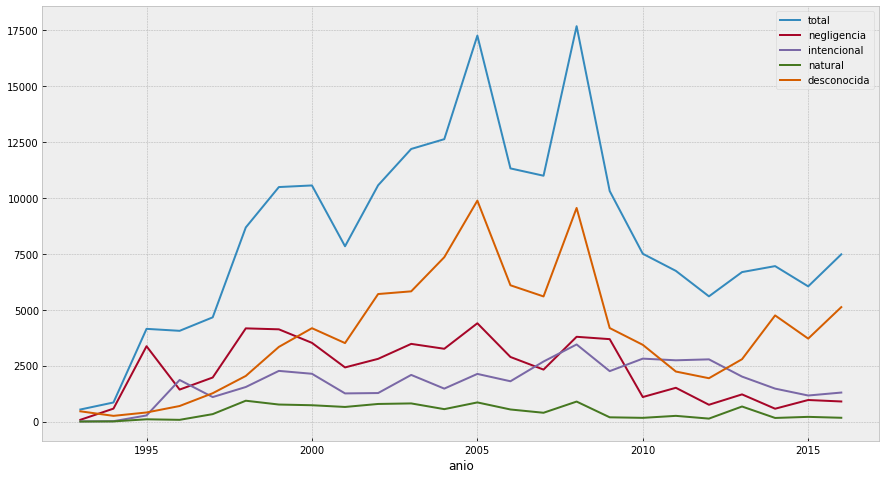

In [6]:
df_anio.plot(y=['total', 'negligencia', 'intencional', 'natural', 'desconocida'],
        kind='line', figsize=(15,8))
plt.show()

En esta figura se puede ver la distribución de la cantidad total de incendios forestales por cada año, y también las distribuciones por cada causa. 

Se puede observar como los incendios de causa desconocida (en naranja) son los que más aportan a la cantidad total, particularmente como hay dos picos de incendios de causa desconocida en el 2005 y en el 2008. Y cómo a partir de este año la cantidad total de incendios disminuye.


Una vez realizado este análisis, se va a considerar ahora los registros agrupados por provincia:

In [7]:
df_provincia = data.groupby('provincia', as_index = True).sum()
df_provincia = df_provincia.loc[:, df_provincia.columns != 'anio']
display(df_provincia.head(3))
display(df_provincia.describe())

,total,negligencia,intencional,natural,desconocida
provincia,,,,,
Buenos Aires,72826,13828,4371,5205,49422
Catamarca,2960,185,1980,14,781
Chaco,7203,1087,1713,17,4386


,total,negligencia,intencional,natural,desconocida
count,24.000000,24.000000,24.000000,24.00000,24.000000
mean,8407.041667,2302.583333,1744.500000,431.75000,3928.208333
std,15477.077632,3084.746638,2725.416059,1083.85998,10176.253154
min,53.000000,5.000000,2.000000,1.00000,0.000000
25%,1425.250000,366.000000,202.250000,16.25000,374.000000
50%,3071.500000,1230.500000,677.500000,60.00000,870.500000
75%,7008.000000,2914.250000,1988.000000,391.25000,2439.250000
max,72826.000000,13828.000000,10354.000000,5205.00000,49422.000000


Lo primero a remarcar de esta tabla es que la desviación estándar es significativamente más grande que la media. Con esto se puede concluir que los datos están muy dispersos, lo que implica que hay provincias con muchos registros de incendios forestales y otras provincias con muy pocos. Al ser tan baja la mediana (3071.5) con respecto a la media, esto sugiere que la mayoría de las provincias tienen pocos registros. 

Esta aclaración (de que el desvío sea más grande que la media) podemos ver que se mantiene en todas las causas de incendios.

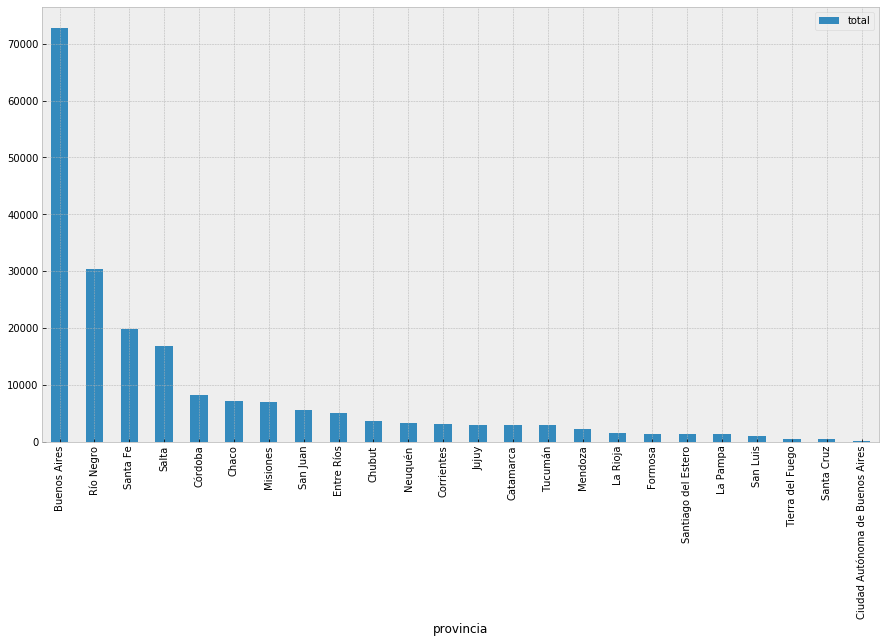

In [8]:
df_provincia.sort_values('total', ascending=False).plot(y=['total'],
        kind='bar', figsize=(15,8))
plt.show()

En este gráfico se puede ver la distribución del total de incendios forestales por provincia, en los últimos 24 años. Claramente la provincia de Buenos Aires tiene muchos registros más que el resto. 

Algo que a priori podría considerarse importante para los incendios forestales es el clima de la provincia, pero al analizar este gráfico, esta influencia no es visible. Ya que provincias con clima húmedo, como Buenos Aires, Santa Fe y Misiones, que se esperarían menos incendios, se encuentran con una gran cantidad de registros. De esta aclaración puede decirse que la actividad agropecuaria puede tener mucha influencia en la cantidad de incendios forestales. 

Una observación que era esperable es el bajo número de incendios en la Ciudad Autónoma de Buenos Aires, siendo prácticamente nula la cantidad comparado con las otras provincas. 

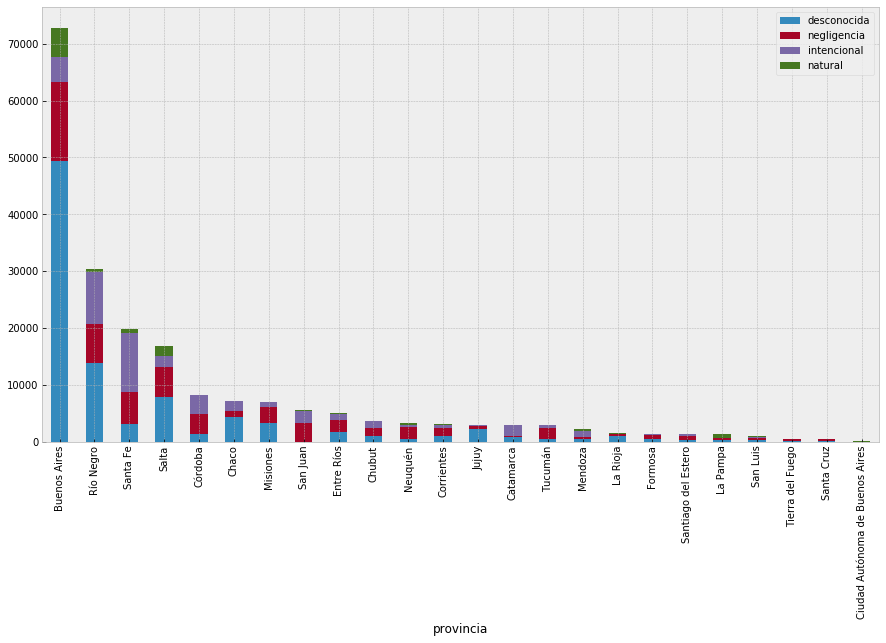

In [9]:
df_provincia.sort_values('total', ascending=False).plot(y=['desconocida', 'negligencia', 'intencional', 'natural'],
        kind='bar', figsize=(15,8), stacked=True)
plt.show()

Al discriminar los incendios por su causa queda en evidencia lo que pasa en la provincia de Buenos Aires, en donde se registraron casi 50000 incendios forestales con causas desconocidas, siendo más del doble de los incendios registrados por otras causas. Al no observar este mismo comportamiento en el resto de las provincias se podría decir que hay una falencia en Buenos Aires para registrar la causa del incendio, y no que sea objetivamente dificil determinar la causa del incendio en más del 60% de los casos.

A partir de la distribución de incendios forestales a lo largo de los años en cada provincia (figura anterior), se observan tres provincias que sobresalen que son Buenos Aires, Rio negro y Santa Fe. Por esta razón se decidió estudiar en cada una de éstas provincias la correlación entre la variable *años* y las *causas*, para observar si existe alguna conexión entre los registros en cada porvincia para un dado año.

In [10]:
data_Buenos_Aires = data[data.provincia == 'Buenos Aires']
data_Buenos_Aires = data_Buenos_Aires.drop(labels = ['provincia','total'], axis = 1)
data_Buenos_Aires = data_Buenos_Aires.set_index('anio')

data_Rio_negro = data[data.provincia == 'Río Negro']
data_Rio_negro = data_Rio_negro.drop(labels = ['provincia','total'], axis = 1)
data_Rio_negro = data_Rio_negro.set_index('anio')

data_Santa_Fe = data[data.provincia == 'Santa Fe']
data_Santa_Fe = data_Santa_Fe.drop(labels = ['provincia','total'], axis = 1)
data_Santa_Fe = data_Santa_Fe.set_index('anio')


Probabilidad_conjunta_anio_causa_BA  = data_Buenos_Aires/data_Buenos_Aires.sum().sum()
print('\n Probabilidad marginal de las causas de incendio para la provincia de Buenos Aires:')
display(Probabilidad_conjunta_anio_causa_BA.sum(axis = 0).to_frame())

Probabilidad_conjunta_anio_causa_RN = data_Rio_negro/data_Rio_negro.sum().sum()
print('\n Probabilidad marginal de las causas de incendio para la provincia de Rio Negro:')
display(Probabilidad_conjunta_anio_causa_RN.sum(axis = 0).to_frame())


Probabilidad_conjunta_anio_causa_SF = data_Santa_Fe/data_Santa_Fe.sum().sum()
print('\n Probabilidad marginal de las causas de incendio para la provincia de Santa Fe:')
display(Probabilidad_conjunta_anio_causa_SF.sum(axis = 0).to_frame())


 Probabilidad marginal de las causas de incendio para la provincia de Buenos Aires:


,0
negligencia,0.189877
intencional,0.060020
natural,0.071472
desconocida,0.678631



 Probabilidad marginal de las causas de incendio para la provincia de Rio Negro:


,0
negligencia,0.223539
intencional,0.303110
natural,0.017733
desconocida,0.455617



 Probabilidad marginal de las causas de incendio para la provincia de Santa Fe:


,0
negligencia,0.279940
intencional,0.519910
natural,0.040422
desconocida,0.159729


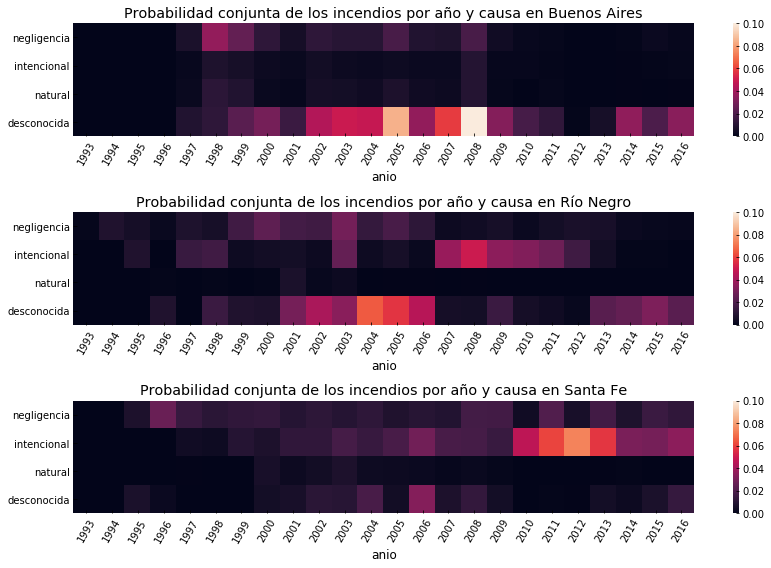

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
sns.heatmap(Probabilidad_conjunta_anio_causa_BA.transpose(), linewidths=0, vmin=0, vmax=0.1, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 60)
ax1.set_title('Probabilidad conjunta de los incendios por año y causa en Buenos Aires')
sns.heatmap(Probabilidad_conjunta_anio_causa_RN.transpose(), linewidths=0, vmin=0, vmax=0.1, ax = ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 60)
ax2.set_title('Probabilidad conjunta de los incendios por año y causa en Río Negro')
sns.heatmap(Probabilidad_conjunta_anio_causa_SF.transpose(), linewidths=0, vmin=0, vmax=0.1, ax = ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 60)
ax3.set_title('Probabilidad conjunta de los incendios por año y causa en Santa Fe')
plt.tight_layout()
plt.show()

Podemos observar que tanto en la provincia de Buenos Aires como en la de Río negro los incendios forestales con mayor frecuencia a lo largo de los años son de causa desconocida (concentrandose en el 2005 y 2009 en Buenos Aires, y en el 2004 y 2005 en Rio Negro), mientras que en la provincia de de Santa Fe el registro a lo largo de los años muestra que los incendios con mayor frecuencia registrados son del tipo intencionales (principalmente en los años entre el 2010 y 2013), lo cual puede atribuirse a que Santa Fe es una provincia que se caracteriza por tener una importante área agrícola.

Por otro lado en las tres provincias notamos que el número de registros de incendios naturales es bajo, y por el origen de éstos, creemos que a lo largo de los años no ha habido un impactado fuerte en épocas de sequias, tormentas electricas o altas temperaturas en estas zonas del pais.


## Conclusiones

La principal conclusión que se puede obtener es que la gran mayoría de los incendios son producidos por la intervención del hombre. En todas las provincias la categoría de los incendios naturales es la minoritaria.

Otra conclusión importante es la diferencia en las distribuciones en de las causas en cada provincia, lo que supone que la cantidad de incendios termina dependiendo de politicas o legislaciones locales.

En cuanto a la evolución temporal se observa un crecimiento en la cantidad de incendios entre los años 2002 y 2009, lo que podría estar causado por el crecimiento en la producción agrícola que sufrió el pais en esos años.